In [1]:
import numpy as np

# for some data and preprocessing
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# for printing stuff
# these are not necessary for running the learning process, just viewing the results
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
import sys
import matplotlib
import sklearn
sys.version, np.__version__, pd.__version__, sklearn.__version__, matplotlib.__version__

('3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]',
 '1.24.3',
 '2.0.1',
 '1.2.2',
 '3.7.1')

# Load some data

In [2]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
data = fetch_california_housing()
# print(data['DESCR'])
print(data['feature_names'])
x_data = data['data']
y_data = data['target'].reshape((-1, 1))

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Select train and test
- make sure targets are a column vector, i.e. shape of (N, 1)

In [3]:
num_samples = x_data.shape[0]
indices = np.random.permutation(num_samples)

train_percent = 0.8
train_size = int(train_percent * num_samples)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

In [24]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(x_data[train_indices])
X_test = x_scaler.transform(x_data[test_indices])

y_scaler = StandardScaler()
Y_train = y_scaler.fit_transform(y_data[train_indices])
Y_test = y_scaler.transform(y_data[test_indices])

print(f'train shapes, X: {X_train.shape}, Y: {Y_train.shape}')
print(f'test shapes, X: {X_test.shape}, Y: {Y_test.shape}')

train shapes, X: (16512, 8), Y: (16512, 1)
test shapes, X: (4128, 8), Y: (4128, 1)


# Functions and such

In [6]:
# glorot uniform (code from gpt)
def initialize_weights(input_size, output_size):
    # Glorot uniform initialization
    limit = np.sqrt(6 / (input_size + output_size))
    weights = np.random.uniform(-limit, limit, (input_size, output_size))
    return weights

# exponential decay (code from gpt)
def exponential_decay(start_lr, end_lr, decay_steps, current_epoch):
    decay_rate = (end_lr / start_lr) ** (1 / decay_steps)
    current_lr = start_lr * (decay_rate ** current_epoch)
    return current_lr

def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def sigmoid_derivative(t):
    return t * (1 - t)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Hyperparameters

In [7]:
num_input_features = X_train.shape[1] # number of features
layer_dimensions = [8, 4, 1]

learning_rate = 0.01
num_epochs = 1000

start_learning_rate = 0.01
end_learning_rate = 0.001

# Declare weights

In [14]:
weights = {}
prior_layer_dim = num_input_features
for i, layer_dim in enumerate(layer_dimensions):
    weights[f'W_{i+1}'] = initialize_weights(prior_layer_dim, layer_dim)
    weights[f'b_{i+1}'] = np.zeros((1, layer_dim))
    prior_layer_dim = layer_dim

# Training

In [30]:
num_layers = len(layer_dimensions)
num_batch_rows = X_train.shape[0]
A_0 = X_train

for i in range(num_epochs):
    ########################
    # forward pass
    ########################
    # for convenience store the A and Z values
    forward_outputs = {f'A_{0}': X_train} 
    forward_prior_activations = {} 
    for j in range(num_layers):
        W = weights[f'W_{j+1}']
        b = weights[f'b_{j+1}']
        Z = np.matmul(forward_outputs[f'A_{j}'], W) + b
        # no transform on last layer
        # don't need to store the last Z, its the same as the last activation
        if j < num_layers - 1:
            forward_outputs[f'A_{j+1}'] = relu(Z)
            forward_prior_activations[f'Z_{j+1}'] = Z
        else:
            forward_outputs[f'A_{j+1}'] = Z
            
    ########################
    # calculate loss
    ########################
    if (i+1) % 100 == 0:
        loss = np.mean(np.square(Y_train - forward_outputs[f'A_{num_layers}']))
        
        _A = X_test
        for j in range(num_layers):
            W = weights[f'W_{j+1}']
            b = weights[f'b_{j+1}']
            Z = np.matmul(_A, W) + b
            _A = relu(Z) if j < num_layers - 1 else Z

        test_loss = np.mean(np.square(Y_test - _A))
        
        print(f'epoch: {i+1}/{num_epochs}, train loss: {loss}, test loss: {test_loss}')
        
    ########################
    # backward pass
    ########################
    backward_grads = {f'dL_dZ{num_layers}': -(2/num_batch_rows)*(Y_train - forward_outputs[f'A_{num_layers}'])}
    for j in reversed(range(1, num_layers)):
        Z = forward_prior_activations[f'Z_{j}']
        W = weights[f'W_{j+1}']
        prior_grad = backward_grads[f'dL_dZ{j+1}']
        backward_grads[f'dL_dZ{j}'] = np.matmul(prior_grad, W.T) * relu_derivative(Z)
        
    
    ########################
    # update weights
    ########################
    # current_learning_rate = exponential_decay(start_learning_rate, end_learning_rate, num_epochs, i)
    current_learning_rate = learning_rate
    for j in reversed(range(num_layers)):
        dZ = backward_grads[f'dL_dZ{j+1}']
        A = forward_outputs[f'A_{j}']
        weights[f'W_{j+1}'] -= current_learning_rate*np.matmul(A.T, dZ)
        weights[f'b_{j+1}'] -= current_learning_rate*np.sum(dZ, axis=0, keepdims=True)

epoch: 100/1000, train loss: 0.484025740521132, test loss: 0.4987371996935638
epoch: 200/1000, train loss: 0.4523646059731267, test loss: 0.4684072362495475
epoch: 300/1000, train loss: 0.4304132308652105, test loss: 0.44676812746734734
epoch: 400/1000, train loss: 0.4128294249492586, test loss: 0.42892862992541886
epoch: 500/1000, train loss: 0.3977996280068891, test loss: 0.41362507127204196
epoch: 600/1000, train loss: 0.38493399489875735, test loss: 0.3999276771827196
epoch: 700/1000, train loss: 0.3737202317649359, test loss: 0.3882644090027184
epoch: 800/1000, train loss: 0.364443395684875, test loss: 0.3784293062700867
epoch: 900/1000, train loss: 0.35684623269726856, test loss: 0.37020864081912663
epoch: 1000/1000, train loss: 0.350320198363228, test loss: 0.36388429030349895


# Check results

In [31]:
_A = X_test
for j in range(num_layers):
    W = weights[f'W_{j+1}']
    b = weights[f'b_{j+1}']
    Z = np.matmul(_A, W) + b
    _A = relu(Z) if j < num_layers - 1 else Z

y_hat = _A
loss = np.mean(np.square(Y_test - y_hat))
print(f'final test loss: {loss}')

final test loss: 0.36382871764731256


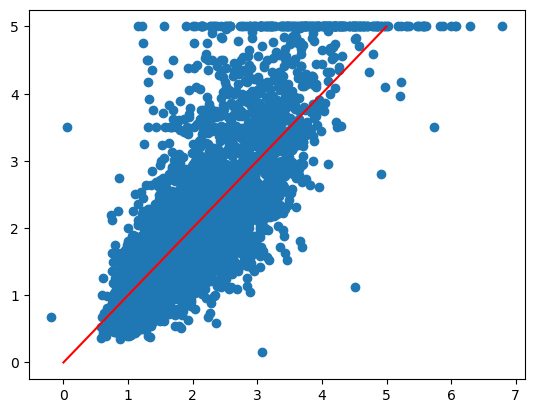

In [32]:
y_pred = y_scaler.inverse_transform(y_hat).flatten()
y_test = y_data[test_indices].flatten()

# pd.DataFrame({'y_pred': y_pred, 'y_true': y_test}).head()
plt.scatter(y_pred, y_test)

x_line = np.linspace(0, int(np.round(np.max(y_test))), 100)
y_line = x_line
plt.plot(x_line, y_line, color='r')